# Flagship vs Pancan Part 3: Trans Effect

Find the trans effects by finding the pearson correlation stats for EGFR proteomics vs all proteomics for each cancer type. Then compare the trans effects between the flagship paper and harmonized pipline.  

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
import statsmodels.stats.multitest

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import cptac.utils as u
import plot_utils as p
import warnings
warnings.filterwarnings('ignore')

In [1]:
import cptac
#load cptac data 
brain = cptac.Gbm()
kidney = cptac.Ccrcc()
ovar = cptac.Ovarian()
colon = cptac.Colon()
brca = cptac.Brca()
luad = cptac.Luad()
hnscc = cptac.Hnscc()
lscc = cptac.Lscc()

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 10)


In [4]:
import cptac.pancan as pc
pc_g = pc.PancanGbm()
pc_hn = pc.PancanHnscc()
pc_l = pc.PancanLuad()
#o = pc.PancanOv()
pc_c = pc.PancanCcrcc()
#col = pc.PancanCoad()
pc_b = pc.PancanBrca()
pc_ls = pc.PancanLscc()
pc_en = pc.PancanUcec()

# Step 1: trans effects data munging 

Call make_trans_df for all cancer types. The function calls wrap_pearson_corr which finds the pearson correleation between EGFR proteomics and all other proteomic columns

It records all FDR Benjamini/Hochberg corrected p values. 

In [6]:
'''
@Param df: Data frame. Takes a data frame of proteomic data frame.
This function takes the data frame from get_proteomics and labels any duplicate columns due to mutliple isoforms.
Then it returns the list of all proteins
'''

def create_prot_list(df):
    #Add _(number) to keep track of duplicates due to multiple isoforms 
    cols = pd.Series(df.columns[:])
    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns=cols
    #get list of proteins
    prot_genes_list = df.columns.values.tolist()
    return prot_genes_list

In [7]:
'''
@Param cancer: cptac data for a cancer Ex brain = cptac.Gbm()

This function makes a df with all trans effects. 
Step 1: Get proteomic data with only tumor samples.
Step 2: For each cancer type, create list of proteins by using create_prot_list function 
which extracts column names and labels duplicate columns caused by multiple isoforms.
Step 3:Use plot_utils function wrap_pearson_corr on df and compare EGFR proteomics to all other proteins in protein list.
Record all FDR corrected p values. 

'''

def make_trans_df(cancer):
    df1_tumor = cancer.get_proteomics(tissue_type= "tumor")
    
    if isinstance(df1_tumor.keys(), pd.core.indexes.multi.MultiIndex):
        df1_tumor = u.reduce_multiindex(df1_tumor, levels_to_drop = 1)
        
    prot_genes_list = create_prot_list(df1_tumor)
    trans_df = p.wrap_pearson_corr(df1_tumor,"EGFR",comparison_columns= prot_genes_list,correction_method='fdr_bh', return_all = True, return_corrected_pvals = True)
    return trans_df
    

# GBM

In [21]:
#Flagship
gbm_df = make_trans_df(brain)
gbm_df


,Comparison,Correlation,P_value
2728,EGFR,1.000000,0.000000e+00
6656,PHLDA1,0.816848,3.507071e-21
3757,GRB2,-0.610889,6.729990e-08
8734,SOCS2,0.562720,3.420388e-06
1528,CDH4,0.559180,3.420388e-06
...,...,...,...
7216,PSMB4,-0.000033,9.998937e-01
7161,PRPF39,0.000123,9.998937e-01
9703,TRAPPC6B,0.000086,9.998937e-01
5351,MKI67,-0.000098,9.998937e-01


In [22]:
#pancan
pancan_gbm_df = make_trans_df(pc_g)



# HNSCC

In [42]:
#Flagship
hnscc_df = make_trans_df(hnscc)
hnscc_df


,Comparison,Correlation,P_value
2687,EGFR,1.000000,0.000000e+00
4684,LANCL2,0.802151,2.402226e-23
6539,PHLDA3,0.688297,6.623837e-14
6537,PHLDA1,0.587915,1.282608e-08
9416,TPBG,0.583325,1.530688e-08
...,...,...,...
6656,PLCD4,0.000142,9.995335e-01
8842,SUPT3H,-0.000184,9.995335e-01
2963,EXTL3,0.000067,9.996077e-01
3393,GALK1,0.000060,9.996077e-01


In [43]:
#pancan
pancan_hnscc = make_trans_df(pc_hn)



In [13]:
#ccRCC flagship
ccrcc_df = make_trans_df(kidney)
#ccRCC pancan 
pancan_ccrcc = make_trans_df(pc_c)

In [14]:
#Luad flagship 
luad_df = make_trans_df(luad)
#luad pancan 
pancan_luad = make_trans_df(pc_l)

In [15]:
#Lscc flagship 
lscc_df = make_trans_df(lscc)
#lscc pancan 
pancan_lscc = make_trans_df(pc_ls)

In [17]:
#brca flagship 
brca_df = make_trans_df(brca)
#brca pancan
pancan_brca = make_trans_df(pc_b)

In [19]:
#ov flagship 
ov_df = make_trans_df(ovar)

In [75]:
#colon flagship
colon_df = make_trans_df(colon)

# Step 2: Compare significant trans gens 

Create venn diagram of significant trans genes from the flagship and pancan pipelines

In [65]:
def compare_og_pancan_trans_genes(og_df, pancan_df,title):
    og_df["Comparison"] = og_df['Comparison'].str.replace(r"_\d","")
    og_genes = og_df.loc[(og_df["P_value"] <= 0.05)].Comparison.to_list()
    
    pancan_df["Comparison"] = pancan_df['Comparison'].str.replace(r"_\d","")
    pancan_genes = pancan_df.loc[(pancan_df["P_value"] <= 0.05)].Comparison.to_list()
    
    og_genes = set(og_genes)
    pancan_genes = set(pancan_genes)
    venn2([og_genes,pancan_genes],("Flagship_genes", "Pancan_genes"))
    plt.title(title)
    
    

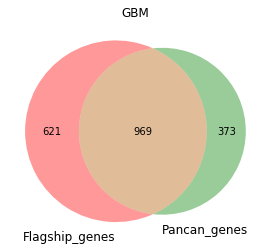

In [47]:
#GBM
compare_og_pancan_trans_genes(gbm_df, pancan_gbm_df,"GBM")

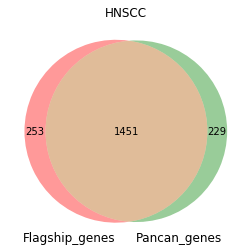

In [66]:
#HNSCC
compare_og_pancan_trans_genes(hnscc_df, pancan_hnscc,"HNSCC")

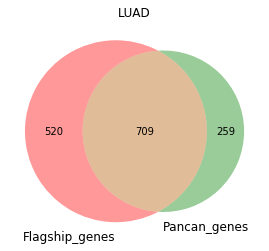

In [67]:
#LUAD
compare_og_pancan_trans_genes(luad_df, pancan_luad,"LUAD")

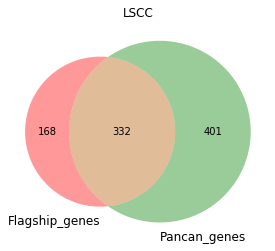

In [68]:
#LSCC
compare_og_pancan_trans_genes(lscc_df, pancan_lscc,"LSCC")

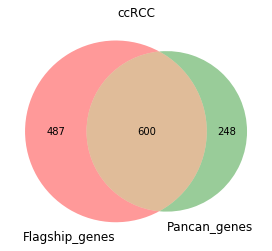

In [69]:
#ccRCC
compare_og_pancan_trans_genes(ccrcc_df, pancan_ccrcc,"ccRCC")

# Step 3:  Determine consistency of trans effects across cancer types

First combine all of the trans effects into one data frame

In [76]:
#combine all of flagship trans df 
og_combined = pd.merge(gbm_df, ccrcc_df, on="Comparison", how = "outer")
og_combined = pd.merge(og_combined, ov_df, on="Comparison", how = "outer")
og_combined = pd.merge(og_combined, luad_df, on="Comparison", how = "outer")
og_combined = pd.merge(og_combined, lscc_df, on="Comparison", how = "outer")
og_combined = pd.merge(og_combined, brca_df, on="Comparison", how = "outer")
og_combined = pd.merge(og_combined, colon_df, on="Comparison", how = "outer")
og_combined = pd.merge(og_combined, hnscc_df, on="Comparison", how = "outer")
og_combined= og_combined[1:]
og_combined

,Comparison,Correlation_x,P_value_x,Correlation_y,P_value_y,Correlation_x,P_value_x,Correlation_y,P_value_y,Correlation_x,P_value_x,Correlation_y,P_value_y,Correlation_x,P_value_x,Correlation_y,P_value_y
1,PHLDA1,0.816848,3.507071e-21,0.254436,0.060261,NaN,NaN,0.260110,0.074530,0.713420,2.644826e-14,0.364797,0.002164,0.386104,0.122847,0.587915,1.282608e-08
2,GRB2,-0.610889,6.729990e-08,-0.217427,0.120342,-0.190090,0.346111,-0.302439,0.020631,-0.198042,2.437176e-01,-0.177379,0.142733,0.150960,0.347409,-0.496325,1.084446e-05
3,SOCS2,0.562720,3.420388e-06,NaN,NaN,NaN,NaN,NaN,NaN,0.472624,1.417921e-02,NaN,NaN,NaN,NaN,-0.014519,9.611234e-01
4,CDH4,0.559180,3.420388e-06,0.148407,0.513490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,DAB2,-0.556402,3.420388e-06,-0.076173,0.673774,0.076981,0.750510,-0.086403,0.597546,-0.072496,7.501117e-01,0.326055,0.003543,-0.147519,0.360266,-0.224967,7.751436e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16814,PIM1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002105,9.917500e-01
16815,HEPHL1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001563,9.931644e-01
16816,SULT6B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001236,9.950909e-01
16817,CLEC4G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001142,9.963768e-01


In [ ]:
#combine all pancan trans dfs
pancan = pd.merge(pancan_gbm_df, pancan_hnscc, on="Comparison", how = "outer")
pancan = pd.merge(pancan, pancan_luad, on="Comparison", how = "outer")
pancan = pd.merge(pancan, pancan_lscc, on="Comparison", how = "outer")
pancan = pd.merge(pancan, pancan_ccrcc, on="Comparison", how = "outer")
pancan = pancan[1:]
